In [12]:
import numpy as np
import sys
import os
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
from skimage import exposure
from skimage.io import imread
from skimage.transform import resize
from skimage.exposure import adjust_gamma
from skimage.measure import label, regionprops
from scipy.stats import mode
import tensorflow as tf
# %pylab inline

In [ ]:
# Data augmentation for batches
class Data_Augmentation():
    def __init__(self, batch_size, validation_size, directory, train_test = 'train'):
        self.batch_size = batch_size
        self.validation_size = validation_size
        self.directory = directory
        nPerSet = {'train': 85, 'testA': 60, 'testB': 20}
        self.image_files = [os.path.join(self.directory, f'{train_test}_{i}.bmp') for i in range(1, nPerSet[train_test] + 1)]
        self.annotation_files = [os.path.join(self.directory, f'{train_test}_{i}_anno.bmp') for i in range(1, nPerSet[train_test] + 1)]

        # load images
        self.full_images = [imread(f)/255 for f in self.image_files]
        self.full_annotations = [imread(f) for f in self.annotation_files]

        # Train-valid split
        self.idxs = np.arange(len(self.image_files))
        np.random.seed(1)
        np.random.shuffle(self.idxs)
        self.val_idxs = self.idxs[:self.validation_size]
        self.train_idxs = self.idxs[self.validation_size:]

    # Data Augmentation
    @staticmethod 
    def _augment(batch_x, batch_y):
        # vertical symmetry
        if(np.random.random() < 0.5):
            batch_x = batch_x[:, ::-1, :, :]
            batch_y = batch_y[:, ::-1, :]
        # horizontal symmetry
        if(np.random.random() < 0.5):
            batch_x = batch_x[:, :, ::-1, :]
            batch_y = batch_y[:, :, ::-1]
        # Gamma
        gamma = (np.random.random() - 0.5) * 2
        if gamma < 0:
            gamma = 1/(1 - gamma)
        else:
            gamma = 1 + gamma
        batch_x_ = batch_x.copy()
        for i in range(len(batch_x)):
            batch_x_[i] = adjust_gamma(batch_x[i], gamma = gamma)
        # Random noise
        batch_x_ += np.random.normal(0, 0.02, size = batch_x.shape)
        return batch_x_,batch_y

In [ ]:
class imageGeneration(Data_Augmentation):
    # read train and valid sets
    def __init__(self, batch_size, validation_size, directory, image_size, train_test = 'train', **kwargs):
        super().__init__(batch_size, validation_size, directory, train_test)

        self.image_size = image_size
        self.batches_per_epoch = len(self.train_idxs) // self.batch_size

        self.val_x = np.array([self.preprocess_image(self.full_images[idx]) for idx in self.val_idxs])
        self.val_y = np.array([self.preprocess_anno(self.full_annotations[idx]) for idx in self.val_idxs])

        self.train_x = np.array([self.preprocess_image(self.full_images[idx]) for idx in self.train_idxs])
        self.train_y = np.array([self.preprocess_anno(self.full_annotations[idx]) for idx in self.train_idxs])

    # Random shuffle of images
    def next_batch(self, n_epochs):
        for e in range(n_epochs):
            np.random.shuffle(self.train_idxs)
            for i in range(self.batches_per_epoch):
                batch_x = self.train_x[i * self.batch_size: (i + 1) * self.batch_size]
                batch_y = self.train_y[i * self.batch_size: (i + 1) * self.batch_size] >0
                yield self._augment(batch_x, batch_y)
    def get_validation_data(self):
        return self.val_x, self.val_y > 0

    def preprocess_image(self, im):
        return resize(im, self.image_size)

    def preprocess_anno(self, anno):
        return resize(anno, self.image_size, preserve_range = True, order = 0, anti_aliasing = False) 

In [ ]:
# Model training / Optimization / Post-processing
class Model():
    def __init__(self, image_size, clf_name, loadFrom = None, lr = 1e-4, eps = 1e-8):
        self.image_size = image_size
        self.clf_name = clf_name
        if(loadFrom == None):
            self.set_model()
            opt = tf.keras.optimizers.Adam(learning_rate = lr, epsilon = eps, name = 'Adam')
            self.model.compile(optimizer = opt, loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = [tf.keras.losses.SparseCategoricalCrossentropy(name = 'crossentropy'), 'accuracy'])
        else:
            self.model = tf.keras.models.load_model(loadFrom, compile = False, custom_objects = {'leaky_relu': tf.nn.leaky_relu})

    def fit(self, n_epochs, dataset, patience = 15):
        validation_data = None
        callbacks = []
        if(len(dataset.val_idxs) > 0):
            callbacks = [tf.keras.callbacks.ModelCheckpoint(f"{self.clf_name}.hdf5", save_best_only = True),tf.keras.callbacks.EarlyStopping(monitor = 'val_crossentropy', patience = patience)]
            validation_data = dataset.get_validation_data()

        return self.model.fit(dataset.next_batch(n_epochs), epochs = n_epochs, steps_per_epoch = dataset.batches_per_epoch, validation_data = validation_data, callbacks = callbacks)

    def predict(self, data):
        return self.model.predict(data)

    # post-processing
    @staticmethod
    def post_process(pred, min_area=400):
        pred_mask = np.argmax(pred, axis = 2)
        # labeling
        lab = label(pred_mask)
        # remove small objects
        for obj in regionprops(lab):
            if(obj.area < min_area):
                lab[lab == obj.label] = 0
            # hole filling
            else:
                region = lab[obj.bbox[0]:obj.bbox[2], obj.bbox[1]:obj.bbox[3]]
                region[obj.filled_image] = obj.label
        return lab

In [ ]:
class evaluation:

    @classmethod
    def evaluate(cls, model, data, train_val, overlap='minimum', min_area=40):

        metrics = []
        if train_val == 'train':
            data_x = [data.full_images[idx] for idx in data.train_idxs]
            data_y = [data.full_annotations[idx] for idx in data.train_idxs]
        elif train_val == 'val':
            data_x = [data.full_images[idx] for idx in data.val_idxs]
            data_y = [data.full_annotations[idx] for idx in data.val_idxs]

        # predict
        for im, anno in zip(data_x, data_y):
            im_ = data.preprocess_image(im)
            pred_image = resize(model.predict(np.array([im_]))[0], im.shape[:2])
            pred_labels = model.post_process(pred_image, min_area)
            metrics += [cls._get_metrics(anno, pred_labels)]
        return np.array(metrics)

    @staticmethod
    def _get_metrics(gt_labels, pred_labels):
        # remove pixels with area smaller than 5
        for i in range(1, gt_labels.max()+1):
            if( (gt_labels==i).sum() < 5 ):
                gt_labels[gt_labels==i] = 0

        trueLabels = np.unique(gt_labels)
        trueLabels = trueLabels[trueLabels>0].astype('int')
        predLabels = np.unique(pred_labels)
        predLabels = predLabels[predLabels>0].astype('int')

        best_matches = np.zeros((len(predLabels),3))
        best_matches[:,0] = predLabels
        for i in range(len(predLabels)):
            predObject = pred_labels==predLabels[i]
            corrRegionInGT = gt_labels[predObject]  
            if corrRegionInGT.max() > 0:
                bestMatch = mode(corrRegionInGT[corrRegionInGT>0])[0][0] 
                matchInGT = gt_labels==bestMatch   
                best_matches[i,1] = bestMatch       
                overlap = predObject*matchInGT 
                best_matches[i,2] = (overlap.sum()/matchInGT.sum())>0.2 # % of overlap 
        
        TP = int(best_matches[:,2].sum())
        FP = int((best_matches[:,2]==0).sum())
        FN = int(len(trueLabels)-TP)
        
        # precision & recall
        precision = TP/(TP+FP)
        recall = TP/(TP+FN)
        
        gt_mask = gt_labels>0
        pred_mask = pred_labels>0
        TP = float(((gt_mask==True)*(pred_mask==True)).sum())
        FP = float(((gt_mask==False)*(pred_mask==True)).sum())
        FN = float(((gt_mask==True)*(pred_mask==False)).sum())
        TN = float(((gt_mask==False)*(pred_mask==False)).sum())
        # segmentation MCC
        MCC = ((TP*TN)-(FP*FN))/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
        return precision, recall, MCC

In [ ]:
class MainModel(Model):
    def __init__(self, image_size, clf_name, loadFrom = None, lr = 1e-4, eps = 1e-8):
        super().__init__(image_size, clf_name, loadFrom = loadFrom, lr = lr, eps = eps)

    def set_model(self):
        inputs = tf.keras.Input(shape = self.image_size + (3,))
        x = tf.keras.layers.Conv2D(32, 3, activation = tf.nn.leaky_relu, padding = 'same')(inputs)
        x = tf.keras.layers.Conv2D(32, 3, activation = tf.nn.leaky_relu, padding = 'same')(x)
        x = tf.keras.layers.MaxPool2D(2)(x)
        x = tf.keras.layers.Conv2D(64, 3, activation = tf.nn.leaky_relu, padding = 'same')(x)
        x = tf.keras.layers.Conv2D(64, 3, activation = tf.nn.leaky_relu, padding = 'same')(x)
        x = tf.keras.layers.MaxPool2D(2)(x)
        x = tf.keras.layers.Conv2D(128, 3, activation = tf.nn.leaky_relu, padding = 'same')(x)
        x = tf.keras.layers.Conv2D(128, 3, activation = tf.nn.leaky_relu, padding = 'same')(x)
        x = tf.keras.layers.UpSampling2D(2)(x)
        x = tf.keras.layers.Conv2D(64, 3, activation = tf.nn.leaky_relu, padding = 'same')(x)
        x = tf.keras.layers.UpSampling2D(2)(x)
        x = tf.keras.layers.Conv2D(32, 3, activation = tf.nn.leaky_relu, padding = 'same')(x)
        outputs = tf.keras.layers.Conv2D(2, 1, activation = tf.nn.softmax)(x)

        self.model = tf.keras.Model(inputs = inputs, outputs = outputs)

Epoch 1/100
15/15 [==============================] - 4s 219ms/step - loss: 0.6918 - crossentropy: 0.6918 - accuracy: 0.5340 - val_loss: 0.6929 - val_crossentropy: 0.6929 - val_accuracy: 0.5057
Epoch 2/100
15/15 [==============================] - 3s 202ms/step - loss: 0.6880 - crossentropy: 0.6880 - accuracy: 0.5614 - val_loss: 0.6940 - val_crossentropy: 0.6940 - val_accuracy: 0.5101
Epoch 3/100
15/15 [==============================] - 3s 202ms/step - loss: 0.6815 - crossentropy: 0.6815 - accuracy: 0.5783 - val_loss: 0.6850 - val_crossentropy: 0.6850 - val_accuracy: 0.5281
Epoch 4/100
15/15 [==============================] - 3s 206ms/step - loss: 0.6698 - crossentropy: 0.6698 - accuracy: 0.6039 - val_loss: 0.6980 - val_crossentropy: 0.6980 - val_accuracy: 0.5283
Epoch 5/100
15/15 [==============================] - 3s 204ms/step - loss: 0.6639 - crossentropy: 0.6639 - accuracy: 0.5937 - val_loss: 0.6970 - val_crossentropy: 0.6970 - val_accuracy: 0.5268
Epoch 6/100
15/15 [================

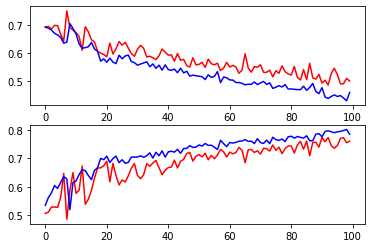

In [ ]:
# parameters
lr = 1e-3
eps = 1e-7
overlap = 'minimum'
max_epochs = 100
patience = 20
directory = "/content/drive/MyDrive/Spring 21/Spring Courses/COMP 548/Project/Warwick_Dataset/"
image_size = (256,384)
batch_size = 5
validation_size = 10
min_area = 40
clf_name = 'custom_model_image'

tf.keras.backend.clear_session()

# Training
generator = imageGeneration(batch_size, validation_size, directory, image_size)
model = MainModel((256,384),clf_name = 'custom_model_image',loadFrom = None)
history = model.fit(max_epochs, generator, patience=patience)

# plots
plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['val_loss'], 'r-')
plt.plot(history.history['loss'], 'b-')
plt.subplot(2,1,2)
plt.plot(history.history['val_accuracy'], 'r-')
plt.plot(history.history['accuracy'], 'b-')
plt.savefig(f'{clf_name}_history.png')

train_metrics = evaluation.evaluate(model, generator, 'train', overlap, min_area)
val_metrics = evaluation.evaluate(model, generator, 'val', overlap, min_area)

with open(f"{clf_name}_metrics.txt", 'w') as fp:
    print("Training perfomance:", file=fp)
    print("Precision\tRecall\tMCC", file=fp)
    print(train_metrics.mean(axis=0), file=fp)
    print(np.median(train_metrics,axis=0), file=fp)
    print(" ---- ", file=fp)
    print("Validation perfomance:", file=fp)
    print("Precision\tRecall\tMCC", file=fp)
    print(val_metrics.mean(axis=0), file=fp)
    print(np.median(val_metrics,axis=0), file=fp)

np.save(f"{'custom_model_image'}_metrics_train.npy", train_metrics)
np.save(f"{'custom_model_image'}_metrics_val.npy", val_metrics)

Epoch 1/100
10/10 [==============================] - 3s 237ms/step - loss: 0.6947 - crossentropy: 0.6947 - accuracy: 0.4961 - val_loss: 0.6905 - val_crossentropy: 0.6905 - val_accuracy: 0.5510
Epoch 2/100
10/10 [==============================] - 2s 205ms/step - loss: 0.6921 - crossentropy: 0.6921 - accuracy: 0.5079 - val_loss: 0.6919 - val_crossentropy: 0.6919 - val_accuracy: 0.5994
Epoch 3/100
10/10 [==============================] - 2s 205ms/step - loss: 0.6908 - crossentropy: 0.6908 - accuracy: 0.5632 - val_loss: 0.6910 - val_crossentropy: 0.6910 - val_accuracy: 0.5512
Epoch 4/100
10/10 [==============================] - 2s 205ms/step - loss: 0.6871 - crossentropy: 0.6871 - accuracy: 0.5747 - val_loss: 0.6884 - val_crossentropy: 0.6884 - val_accuracy: 0.5482
Epoch 5/100
10/10 [==============================] - 2s 204ms/step - loss: 0.6828 - crossentropy: 0.6828 - accuracy: 0.5626 - val_loss: 0.6768 - val_crossentropy: 0.6768 - val_accuracy: 0.6654
Epoch 6/100
10/10 [================

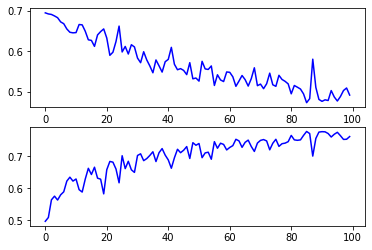

In [ ]:
# parameters
lr = 1e-3
eps = 1e-7
overlap = 'minimum'
max_epochs = 100
patience = 20
directory = "/content/drive/MyDrive/Spring 21/Spring Courses/COMP 548/Project/Warwick_Dataset/"
image_size = (256,384)
batch_size = 5
validation_size = 10
min_area = 40
clf_name = 'custom_model_image'

tf.keras.backend.clear_session()

# model = Model(image_size, clf_name, loadFrom=f'{clf_name}.hdf5')
model = CustomModel((256,384),clf_name = 'custom_model_image',loadFrom = None)

# Compute & save metrics
generator = imageGeneration(batch_size, validation_size, directory, image_size, train_test='testA')
metrics = evaluation.evaluate(model, generator, 'train', overlap, min_area)
history = model.fit(max_epochs, generator, patience=patience)

plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['loss'], 'b-')
plt.subplot(2,1,2)
plt.plot(history.history['accuracy'], 'b-')
plt.savefig(f'{clf_name}_history.png')

with open(f"{clf_name}_testA_metrics.txt", 'w') as fp:
    print("Test A")
    print("Precision\tRecall\tMCC", file=fp)
    print(metrics.mean(axis=0), file=fp)
    print(np.median(metrics,axis=0), file=fp)
    
np.save(f"{clf_name}_testA_metrics.npy", metrics)

generator = imageGeneration(batch_size, validation_size, directory, image_size, train_test='testB')
metrics = evaluation.evaluate(model, generator, 'train', overlap, min_area)

with open(f"{clf_name}_testB_metrics.txt", 'w') as fp:
    print("Test B")
    print("Precision\tRecall\tMCC", file = fp)
    print(metrics.mean(axis = 0), file = fp)
    print(np.median(metrics,axis = 0), file = fp)
    
np.save(f"{clf_name}_testB_metrics.npy", metrics)